In [246]:
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import LSTM, Input, Masking
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
import keras
import keras.backend as K

In [247]:
from pointer_lstm import PointerDecoder
from sorting_dataset import gen_data, gen_jagged_data

In [248]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [249]:
%reload_ext autoreload
%autoreload 2

np.random.seed(17)

In [251]:
N = 10000
max_seq_len = 5
output_size = max_seq_len + 1

# X, y = gen_data(N, max_seq_len, low=0, high=1000)
X, y = gen_jagged_data(N, max_seq_len, low=1)

# Pad the (jagged) sequences
X = pad_sequences(X, maxlen=max_seq_len + 1, value=-1, padding='post', truncating='post', dtype=np.float32)
y = pad_sequences(y, value=0, padding='post', truncating='post') # maxlen=output_size, 

# Shuffle the sequences
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X.shape, y.shape

((10000, 6), (10000, 6))

In [252]:
X[:2], y[:2]

(array([[ 1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        ],
        [ 1.        ,  0.35632184,  0.62068963,  0.06896552,  1.        ,
         -1.        ]], dtype=float32),
 array([[1, 0, 0, 0, 0, 0],
        [4, 2, 3, 1, 5, 0]], dtype=int32))

In [253]:
split = int(0.8 * N)

_X = np.expand_dims(X, axis=2)
# _X = np.repeat(_X, 4, axis=2)

# OHE the labels
_y = to_categorical(y, num_classes=output_size)
# _y = _y[:, :output_size]

X_train = _X[:split]
y_train = _y[:split]

X_test = _X[split:]
y_test = _y[split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 6, 1), (8000, 6, 6), (2000, 6, 1), (2000, 6, 6))

In [254]:
seq_shape = X_train.shape[1:]
hidden_units = 64
batch_size = 32

inputs = Input(shape=seq_shape, name='input', batch_size=batch_size)
masking = Masking(mask_value=-1, name='masking') 
masked = masking(inputs)
encoder = LSTM(hidden_units, name='encoder', return_sequences=True, return_state=True)
enc, state_h, state_c =  encoder(masked)

decoder = PointerDecoder(hidden_units, output_size=output_size, name='decoder')
dec = decoder(enc, initial_state=[state_h, state_c])

model = Model(inputs, dec)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(32, 6, 1)]         0           []                               
                                                                                                  
 masking (Masking)              (32, 6, 1)           0           ['input[0][0]']                  
                                                                                                  
 encoder (LSTM)                 [(32, 6, 64),        16896       ['masking[0][0]']                
                                 (32, 64),                                                        
                                 (32, 64)]                                                        
                                                                                           

In [261]:
opt = optimizers.adam_v2.Adam(learning_rate=1e-3)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [262]:
nb_epochs = 20
h = model.fit(X_train, y_train,
            epochs=nb_epochs, batch_size=batch_size)

Epoch 1/20
250/250 [==============================] - 11s 7ms/step - loss: 0.4290 - accuracy: 0.5837
Epoch 2/20
250/250 [==============================] - 2s 7ms/step - loss: 0.1420 - accuracy: 0.8958
Epoch 3/20
250/250 [==============================] - 2s 7ms/step - loss: 0.0956 - accuracy: 0.9284
Epoch 4/20
250/250 [==============================] - 2s 7ms/step - loss: 0.0771 - accuracy: 0.9432
Epoch 5/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0651 - accuracy: 0.9524
Epoch 6/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0584 - accuracy: 0.9570
Epoch 7/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0554 - accuracy: 0.9572
Epoch 8/20
250/250 [==============================] - 2s 9ms/step - loss: 0.0473 - accuracy: 0.9652
Epoch 9/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0453 - accuracy: 0.9650
Epoch 10/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0422 - accuracy: 0.968

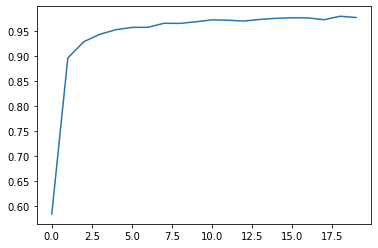

In [263]:
plt.plot(h.history['accuracy'])

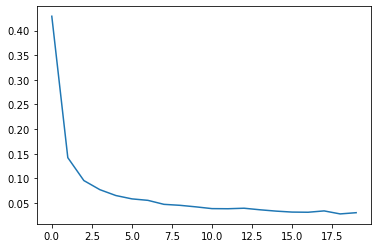

In [264]:
plt.plot(h.history['loss'])

In [265]:
model.evaluate(X_test[:-16], y_test[:-16], batch_size=batch_size)

62/62 [==============================] - 3s 3ms/step - loss: 0.0405 - accuracy: 0.9655


[0.04046221077442169, 0.9654600024223328]

In [266]:
X_test[:2]

array([[[ 1.        ],
        [ 0.2857143 ],
        [ 0.86734694],
        [ 0.53061223],
        [-1.        ],
        [-1.        ]],

       [[ 0.30232558],
        [ 1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ]]], dtype=float32)

In [267]:
y_pred = model.predict(X_test[:-16])

In [268]:
y_pred_pos = y_pred.argmax(axis=2)
y_pred_idx = y_pred.argmax(axis=1)
y_pred_pos[:10] #, y_pred_idx[:2]

array([[2, 4, 3, 1, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [2, 1, 3, 0, 0, 0],
       [2, 1, 3, 0, 0, 0],
       [3, 2, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [3, 2, 1, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [2, 5, 1, 4, 3, 0]])

In [269]:
y_test_pos = y_test.argmax(axis=2)
y_test_idx = y_test.argmax(axis=1)
y_test_pos[:10] #, y_test_idx[:2]

array([[2, 4, 3, 1, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [2, 1, 3, 0, 0, 0],
       [2, 1, 3, 0, 0, 0],
       [3, 2, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [3, 2, 1, 0, 0, 0],
       [1, 2, 0, 0, 0, 0],
       [2, 5, 1, 4, 3, 0]])

In [270]:
_X = X_test[:2]
_X

array([[[ 1.        ],
        [ 0.2857143 ],
        [ 0.86734694],
        [ 0.53061223],
        [-1.        ],
        [-1.        ]],

       [[ 0.30232558],
        [ 1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ]]], dtype=float32)

In [271]:
m = masking(_X)
e, h, c = encoder(m)
d = decoder(e, [h,c])
d

<tf.Tensor: shape=(2, 6, 6), dtype=float32, numpy=
array([[[0.0000000e+00, 9.5153043e-18, 1.0000000e+00, 7.1676656e-18,
         3.2728147e-14, 0.0000000e+00],
        [0.0000000e+00, 3.3691601e-13, 9.5591881e-09, 2.1164138e-12,
         1.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.1381923e-06, 4.3037746e-10, 9.9997532e-01,
         2.3465291e-05, 0.0000000e+00],
        [0.0000000e+00, 9.9998820e-01, 1.0274046e-12, 1.1828455e-05,
         5.1299026e-13, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 1.0000000e+00, 1.5772842e-21, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 8.1876265e-13, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
      

In [89]:
def compute_accuracy(_y_true, _y_pred):
    acc = keras.metrics.Accuracy()
    return acc(_y_true, _y_pred).numpy()

In [90]:
compute_accuracy(y_pred_idx.argsort(), y_pred_pos)
compute_accuracy(y_test_idx.argsort(), y_test_pos)
compute_accuracy(y_pred_pos, y_test_pos[:-16])
compute_accuracy(y_pred_idx, y_test_idx[:-16])

0.65087366

In [91]:
X_ = X_test[:batch_size]
X_[0] = [[0.2], [1.0], [-1], [-1], [-1], [-1]]
X_[1] = [[1.0], [1.0], [1.0], [1.0], [1.0], [-1]]
X_[2] = [[1], [0.1], [0.1], [1], [0.1], [-1]]

X[:3]

array([[ 0.27586207,  0.63793105,  0.39655173,  1.        , -1.        ,
        -1.        ],
       [ 0.09589041,  0.9726027 ,  1.        ,  0.4520548 , -1.        ,
        -1.        ],
       [ 0.22105263,  1.        , -1.        , -1.        , -1.        ,
        -1.        ]], dtype=float32)

In [93]:
y_pred = model.predict(X_)
y_pred_pos = y_pred.argmax(axis=2)
y_pred_idx = y_pred.argmax(axis=1)
y_pred_pos[:3]#, y_pred_idx[:3]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1]])

In [166]:
# K.sum( K.cast((e[:, -1] == h),  dtype=np.int32) ) / K.prod(h.shape)